# Классификация спектров

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import scale as std_scale, robust_scale

from scipy.signal import find_peaks, find_peaks_cwt, peak_widths

import numpy as np
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale
import sklearn.metrics as metrics

import matplotlib.pyplot as plt
import matplotlib.animation as ani

import mlgrad.models as models
import mlgrad.regr as regr
import mlgrad.cls as cls
import mlgrad.plots as plots
import mlgrad.funcs as funcs
import mlgrad.funcs2 as funcs2
import mlgrad.loss as loss
import mlgrad.gd as gd
import mlgrad.smooth as smooth


import rampy
import pybaselines

In [3]:
def plot_spectra(d_191, d_606, ax=None):
    if ax is None:
        ax = plt.gca()
    for item_191, item_606 in zip(d_191, d_606):
        ax.plot(np.mean(item_191[2], axis=0), color='r', linewidth=1.0, label='191', alpha=0.25)
        ax.plot(np.mean(item_606[2], axis=0), color='b', linewidth=1.0, label='606', alpha=0.25)
    # ax.legend(loc="upper left")
    ax.set_xlabel("$k$ (индекс точки)")
    ax.set_ylabel("Интенсивность (нормированная)")
    ax.set_title("Спектры (усредненные) по классам и значения коэффициентов")
    ax.minorticks_on()

def plot_params(param, ax=None):
    if ax is None:
        ax = plt.gca()
    pp = np.asarray(param)
    ymax = np.asarray(pp[1:].copy())
    ymin = np.asarray(pp[1:].copy())
    np.putmask(ymax, ymax<0, 0)
    np.putmask(ymin, ymax>0, 0)
    n = len(ymin)
    print(n)
    ax.vlines(range(n), ymin, ymax, color='k', linewidth=1., label=r"Вектор коэффициентов $\mathbf{w}$")
    ax.minorticks_on()
    ax.set_ylabel(r"$w_k$")
    # ax.legend(loc="upper right")


In [50]:
def load_data(fold):
    Xs = []
    Ys = []
    
    for fname in os.listdir(fold):
        if not fname.endswith(".txt"):
            continue
        xy = np.loadtxt(f"{fold}/{fname}", delimiter="\t")
        xy = xy[40:]
        xs = xy[:,0].reshape(-1)
        ys = xy[:,1].reshape(-1)
        ys -= ys.min()
        # ys /= np.trapz(ys, xs)
        # ys *= 1000
        Xs.append(xs)
        Ys.append(ys)
    Xs, Ys =  np.array(Xs), np.array(Ys)
    return Xs, Ys

In [51]:
def load_data_folder(root):
    d_191 = []
    d_606 = []
    fnames = []
    for f in os.scandir(root):
        if f.is_dir():
            if "3_4" in f.name or "3_5" in f.name:
                continue
            fnames.append(f.name)
    fnames.sort()
    for fname in fnames:
        print(fname)
        for sf in os.scandir(f"{root}/{fname}"):
            if sf.is_dir():
                print('\t', sf.name)
                Xs, Ys = load_data(f"{root}/{fname}/{sf.name}")
                if '191' in sf.name:
                    d_191.append((fname, Xs, Ys))
                elif '606' in sf.name:
                    d_606.append((fname, Xs, Ys))
    d_191.sort()
    d_606.sort()
    return d_191, d_606                

In [76]:
from mlgrad.outl import despike_whittaker

def preprocess_spectras(Xs, Ys):
    for k in range(len(Xs)):
        xs = Xs[k]
        ys = Ys[k]
        
        ys = despike_whittaker(ys, m=5, tau=3.5)
        ys = despike_whittaker(ys, m=5, tau=3.5)
        ys = despike_whittaker(ys, m=5, tau=3.5)
        ys = smooth.whittaker(ys, tau=10.0)
        # ys = rampy.smooth(xs, ys, method="whittaker", Lambda=6.0)
        bs, _ = pybaselines.whittaker.aspls(ys, x_data=xs, lam=1.0e4)
        # bs, _ = pybaselines.whittaker.arpls(ys, lam=1.0e5)
        # bs, _ = pybaselines.morphological.mor(ys)
        # bs, _ = pybaselines.morphological.mpls(ys, lam=1.0e6)
        ys = ys - bs

        # ys = rampy.smooth(xs, ys, method="whittaker", Lambda=10.0)

        ys -= ys.min()
        ys /= np.trapz(ys, xs)
        ys *= 1000
        # ys = rampy.smooth(xs, ys, method="whittaker", Lambda=4.0)
        Ys[k,:] = ys


def plot_spectras(name, V):
    fname = V[0]
    Xs = V[1]
    Ys = V[2]
    for k in range(len(Xs)):
        xs = Xs[k]
        ys = Ys[k]        
        # plt.plot(ys, color=color, linewidth=0.2, marker='s', markersize=2)
        if name == '191':
            color = 'r'
        elif name == '606':
            color = 'b'
        plt.plot(ys, color=color, linewidth=0.2, alpha=0.75) #, marker='s', markersize=1)

    plt.plot(np.median(Ys, axis=0), color='k', linewidth=1.5) #, marker='s', markersize=1)
    # plt.hlines(0, -30, 1000, linewidth=0.5, colors='k', linestyle='--')
    # plt.xlim(0, 200)
    plt.minorticks_on()
    plt.xlabel("Индекс (длины волны)")
    plt.ylabel("Интенсивность (нормированная)")
    plt.title(f"Класс: {name} | {fname}")
    plt.grid(1)


In [77]:
d_191, d_606 = load_data_folder("SAXXX")
print(len(d_191), len(d_606))

20231012_16_SA_191_606_6_4_(less30_more10)_532nm
	 SA_606_6_4_more10_less30
	 SA191_6_4_more10_less30
20231017_20_SA_191_606_6_5_(less30_more10)_532nm
	 SA_191_6_5_less30_ more10
	 SA_606_6_5_less30_ more10
20231113_27_SA_191_606_6_4_(less30_more10)_532nm
	 SA_606_6_4_less 30_more10
	 SA_191_6_4_less 30_more10
20231130_28_SA_191_606_6_5_(less30_more10)_repeat#2_532nm.rar
	 SA_606_6_4_less 30_more10
	 SA_191_6_4_less 30_more10
20240411_35_SA_606_191_6_4_(less30_more10)_Ag#G(01.03.24)_532nm_1
	 SA_191_6_4_(less30_more10)_
	 SA_606_6_4_(less30_more10)_
20240411_35_SA_606_191_6_5_(less30_more10)_Ag#G(01.03.24)_532nm_2
	 SA_606_6_5_(less30_more10)_
	 SA_191_6_5_(less30_more10)_
20240412_36_SA_606_191_6_4_6_5_(less30_more10)_Ag#G(01.03.24)_532nm
	 SA_606_6_5_(less30_more10)
	 SA_191_6_5_(less30_more10)
7 7


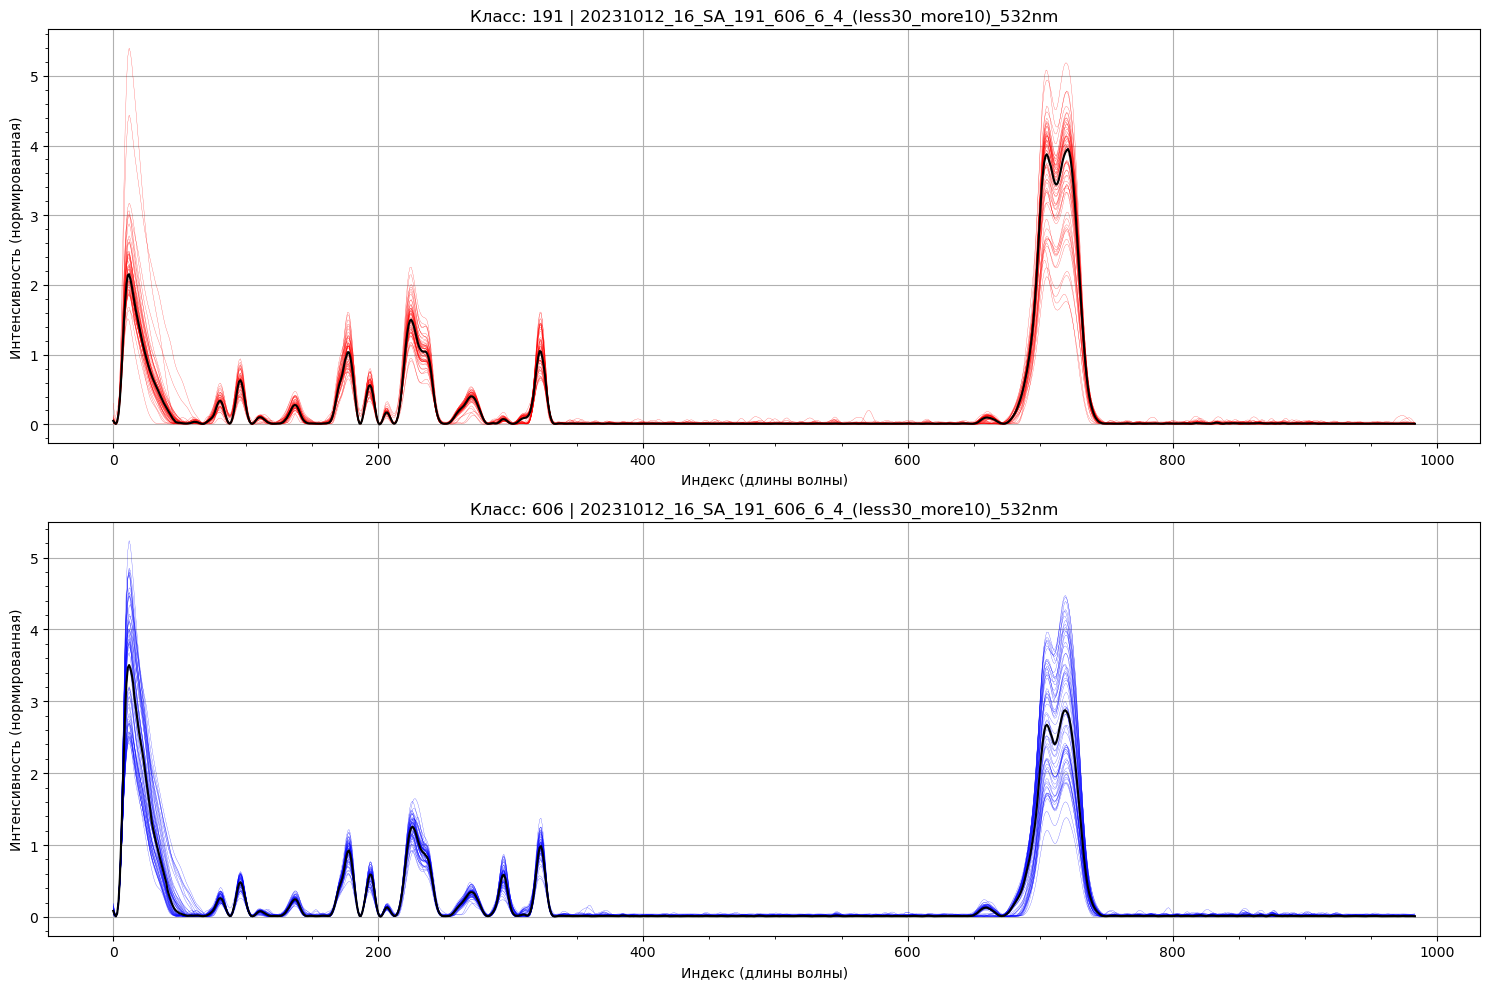

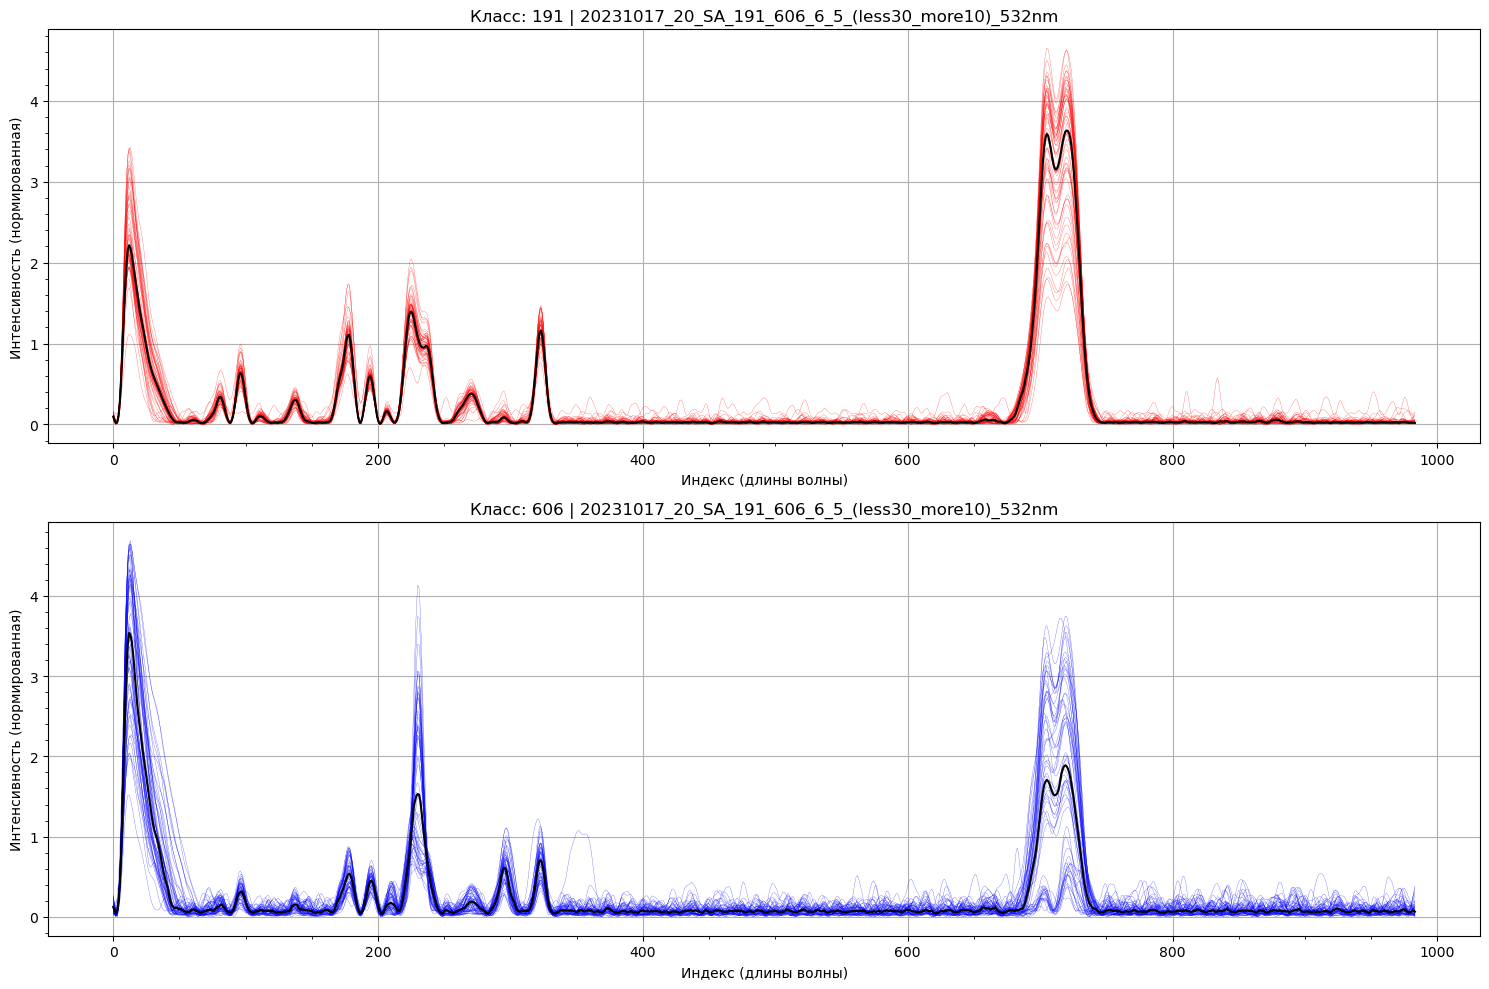

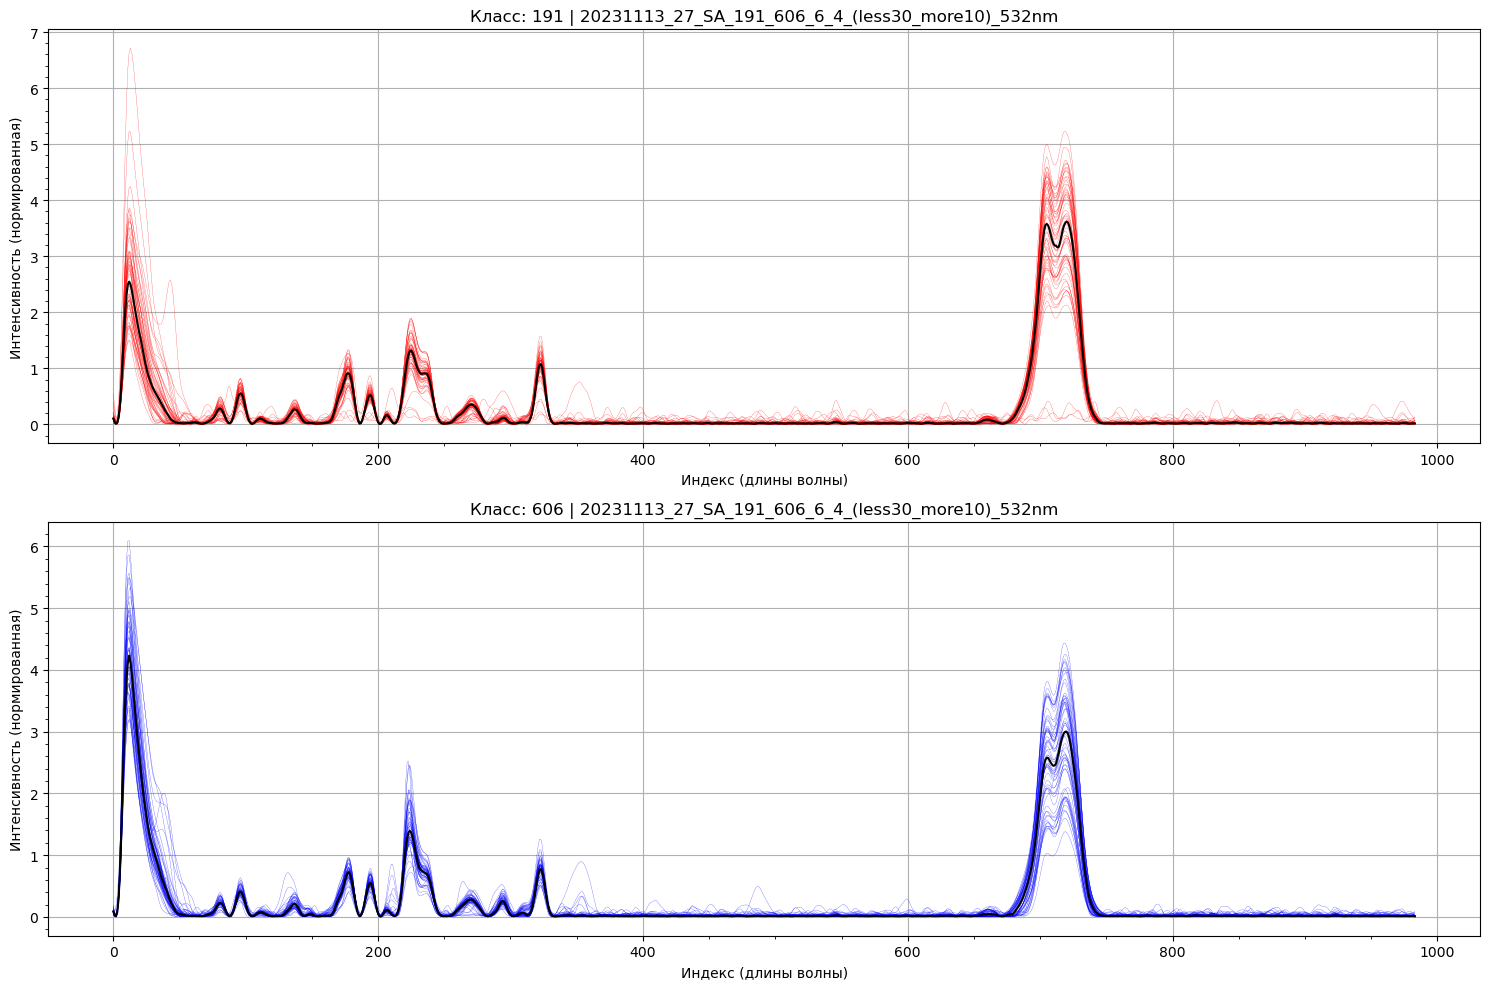

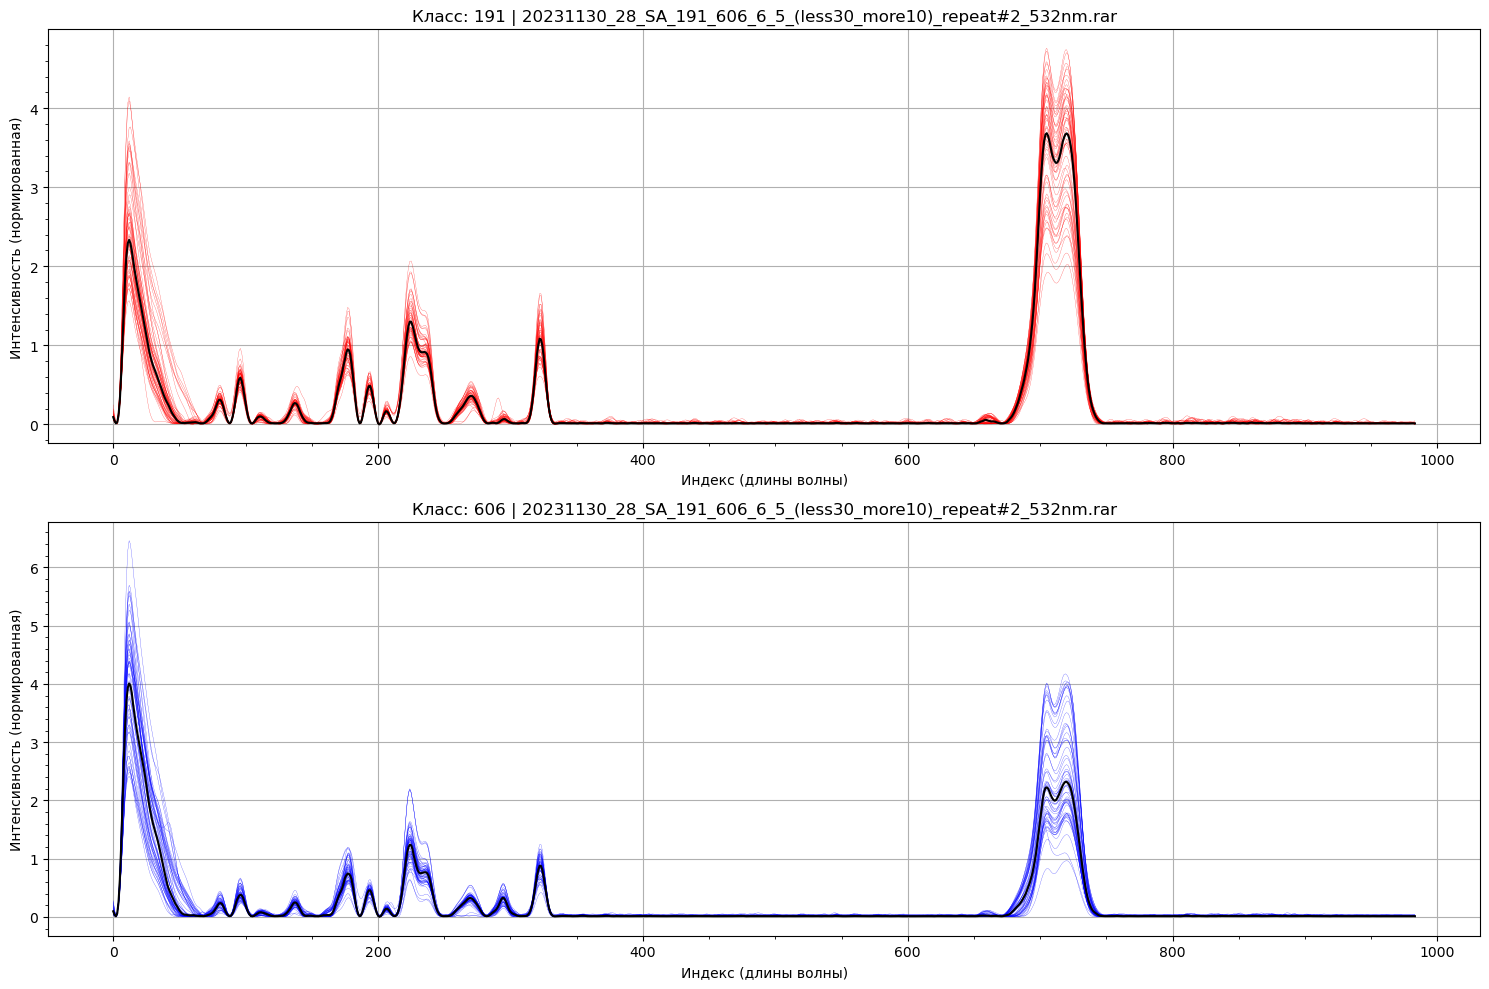

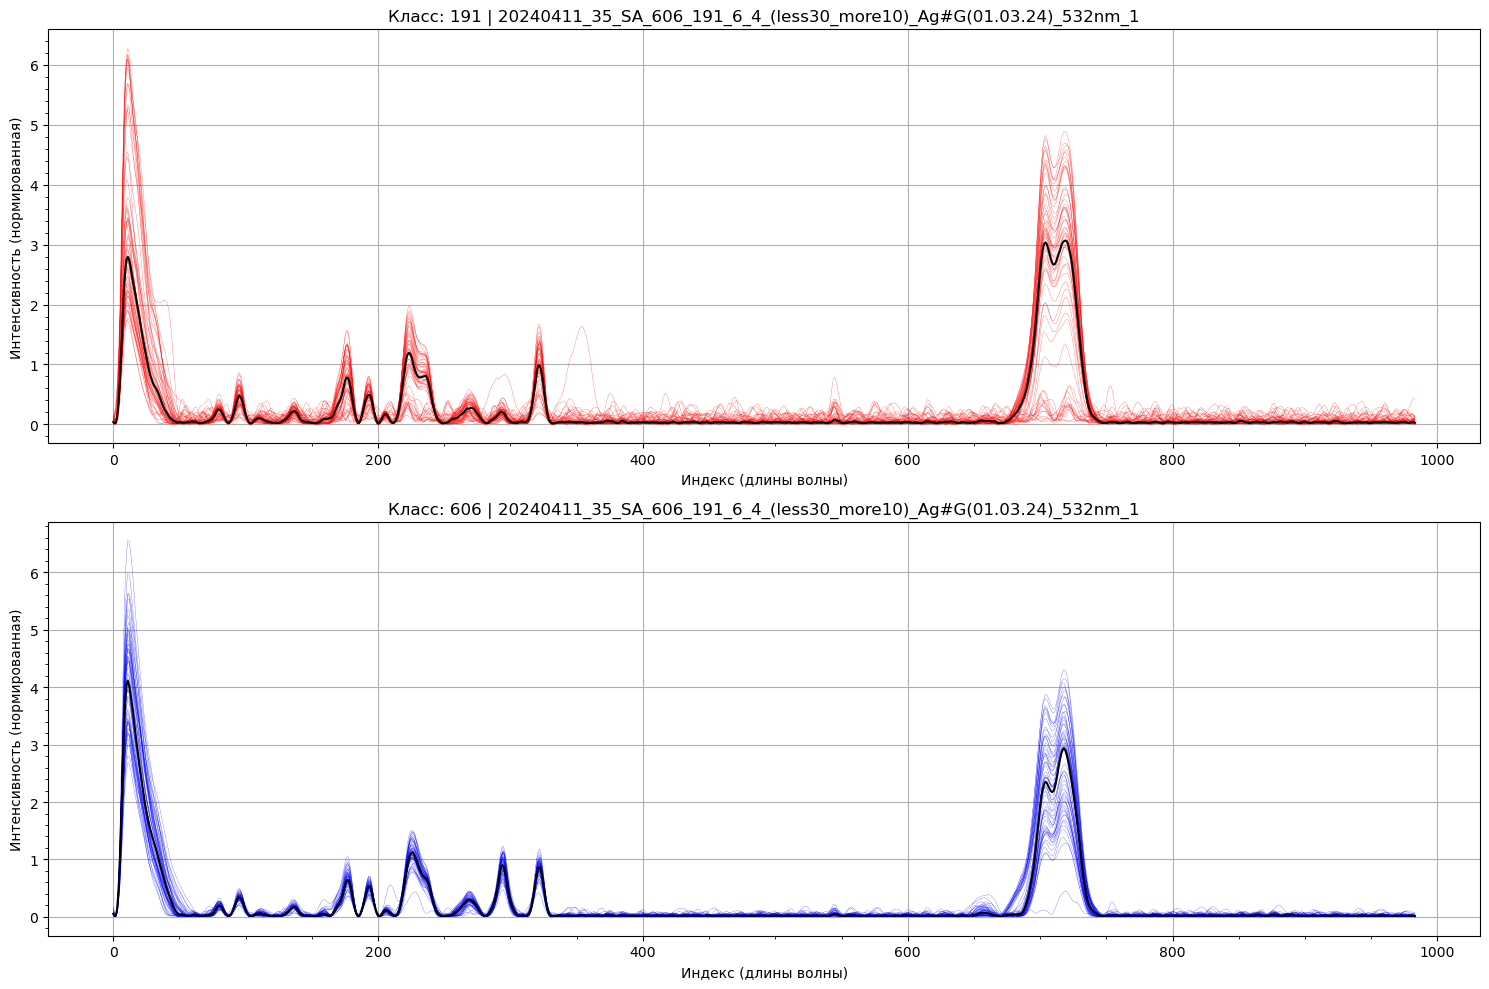

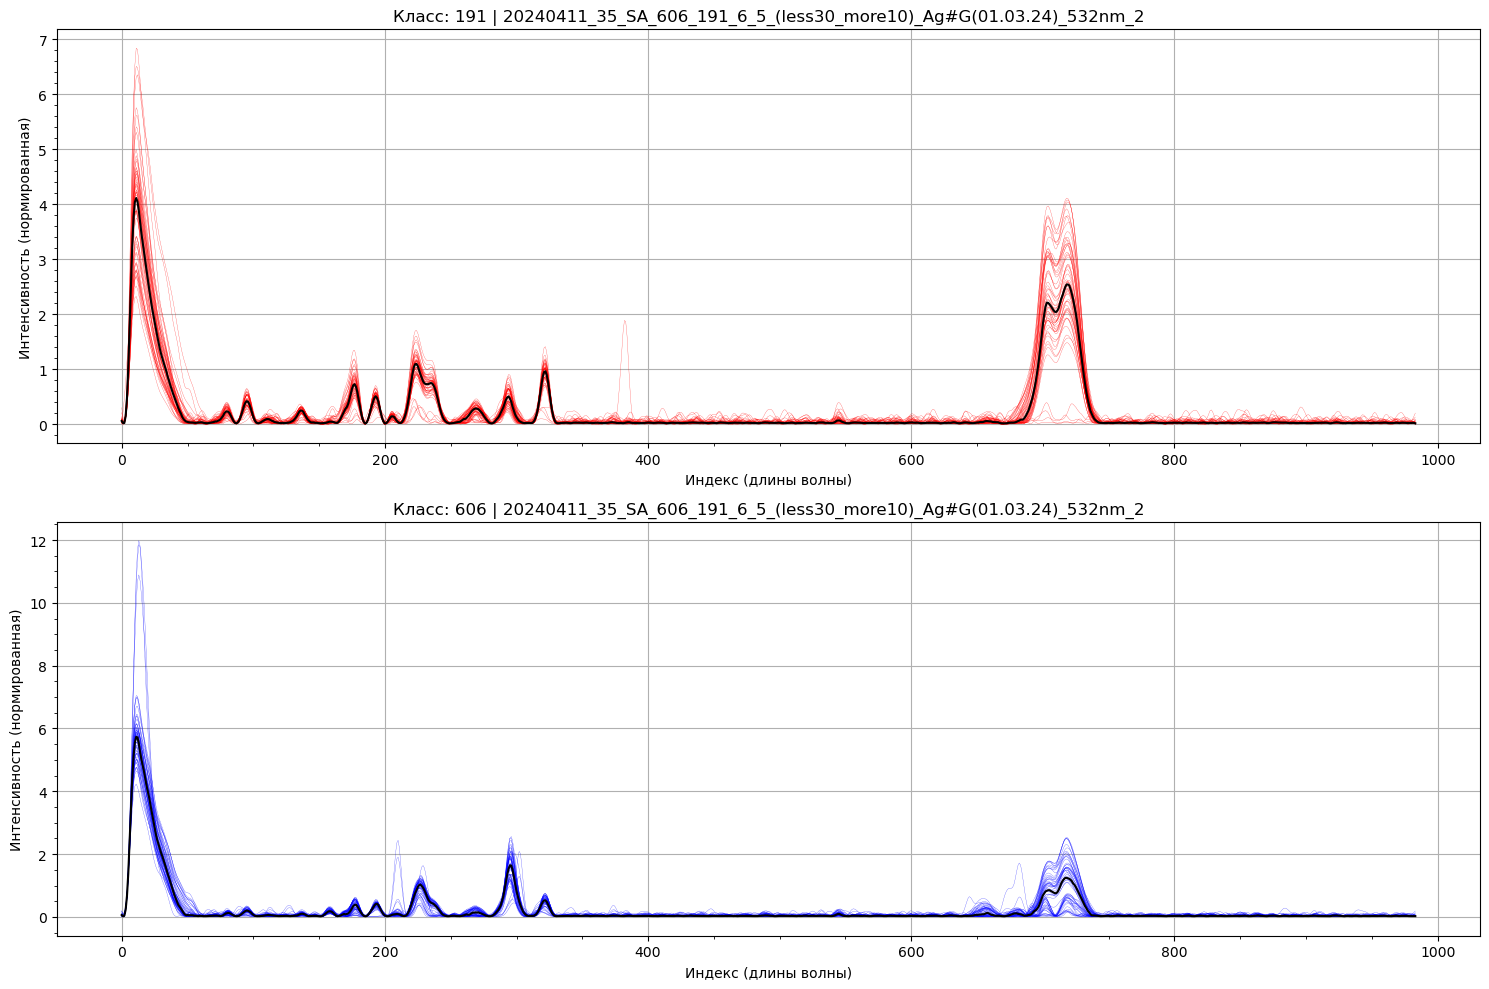

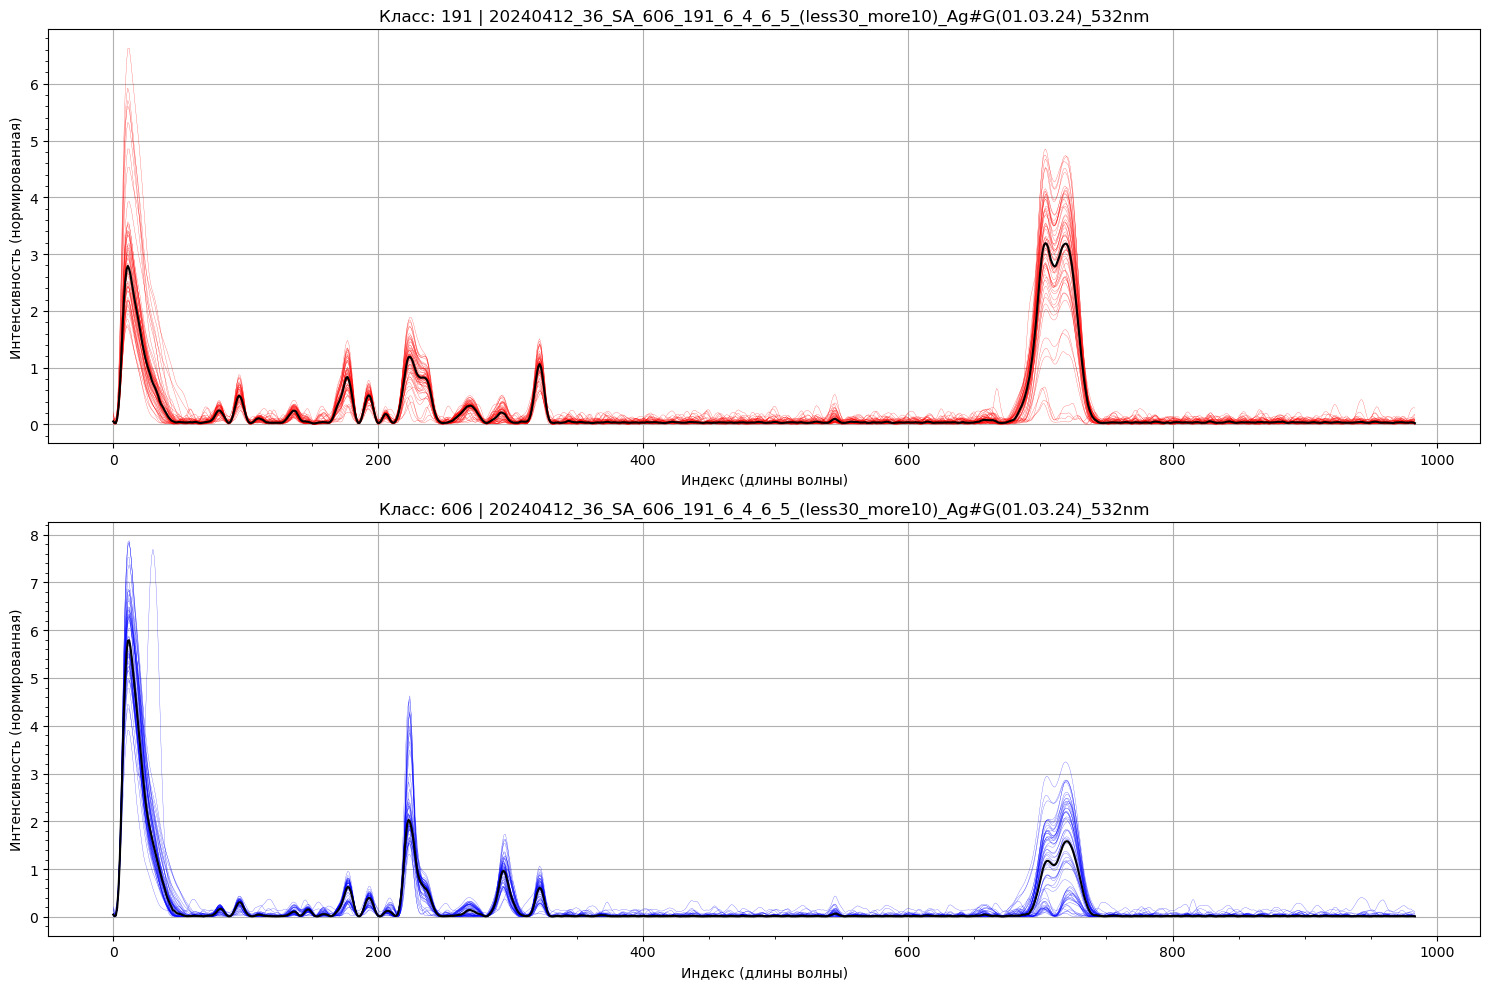

In [78]:
for v_191, v_606 in zip(d_191, d_606):
    plt.figure(figsize=(15,10))
    plt.subplot(2,1,1)
    preprocess_spectras(v_191[1], v_191[2])    
    plot_spectras('191', v_191)
    
    plt.subplot(2,1,2)
    preprocess_spectras(v_606[1], v_606[2])
    plot_spectras('606', v_606)
        
    plt.tight_layout()
    plt.show()


In [19]:
def concatenate_data(d, cls):
    YYs = []
    for _, _, Ys in d:
        YYs.append(Ys)
    YYs = tuple(YYs)
    XX = np.concatenate(YYs, axis=0)
    YY = np.full(len(XX), cls, 'd')
    return XX, YY

XX1, YY1 = concatenate_data(d_191, 1)
XX2, YY2 = concatenate_data(d_606, -1)
XX = np.concatenate((XX1, XX2), axis=0)
YY = np.concatenate((YY1, YY2), axis=0)

N, n = XX.shape
print(r"Размерность вектора x:", n)

Размерность вектора x: 986


In [20]:
hinge_loss = loss.MarginLoss(funcs.Hinge(1.0))
l2_reg = funcs2.SquareNorm()
l1_reg = funcs2.AbsoluteNorm()
soft_l1_reg = funcs2.SoftAbsoluteNorm(0.0001)
sigmoidal_func = funcs.Sigmoidal(6.0)
sigmoidal_func2 = funcs.Sigmoidal(2.0)
sq_loss = loss.ErrorLoss(funcs.Square())

### Линейное разделение (функция Хинжа, без регуляризации)

$$
w^\star = \arg \min_{\mathbf{w}} 
\frac{1}{N}\sum_{k=1}^N 
H\bigl(y_k[w_0+(\mathbf{w},\mathbf{x}_k)]\bigr)
$$
$$
H(u) = \max(-u,0)
$$

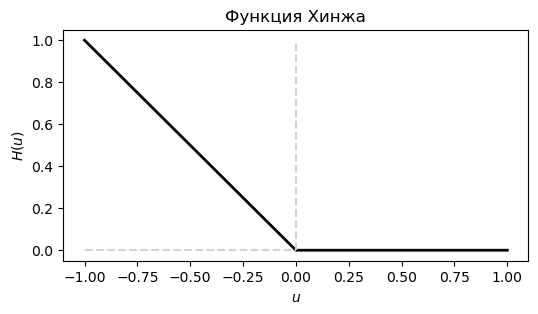

In [10]:
# График функции Хинжа
plt.figure(figsize=(6,3))
plt.plot([-1,0,1],[1,0,0], linewidth=2, color='k')
plt.title("Функция Хинжа")
plt.hlines(0,-1,0, linestyles='dashed', color='LightGrey')
plt.vlines(0,0,1, linestyles='dashed', color='LightGrey')
plt.xlabel(r"$u$")
plt.ylabel(r"$H(u)$")
plt.show()

In [11]:
mod1 = models.LinearModel(n) # линейная модель

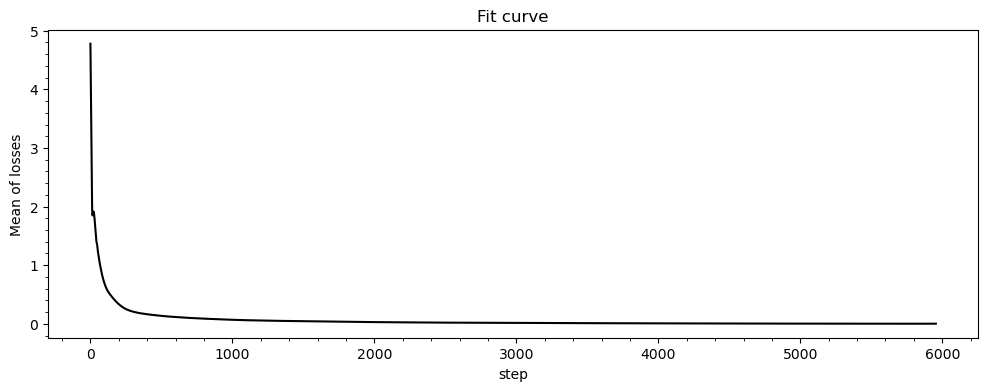

Относительное число правильных ответов: 0.997624703087886 1.0


In [12]:
alg1 = cls.classification_as_regr(XX, YY, mod1,
                                  lossfunc=hinge_loss, 
                                  # normalizer=gd.Masked(mod1.n_param, 1.0e-5),
                                  h=0.002, n_iter=10000)

plt.figure(figsize=(12,4))
plots.plot_losses(alg1)
plt.show()

print("Относительное число правильных ответов:", 
        metrics.accuracy_score(YY1, np.sign(mod1.evaluate_all(XX1))),
        metrics.accuracy_score(YY2, np.sign(mod1.evaluate_all(XX2))))

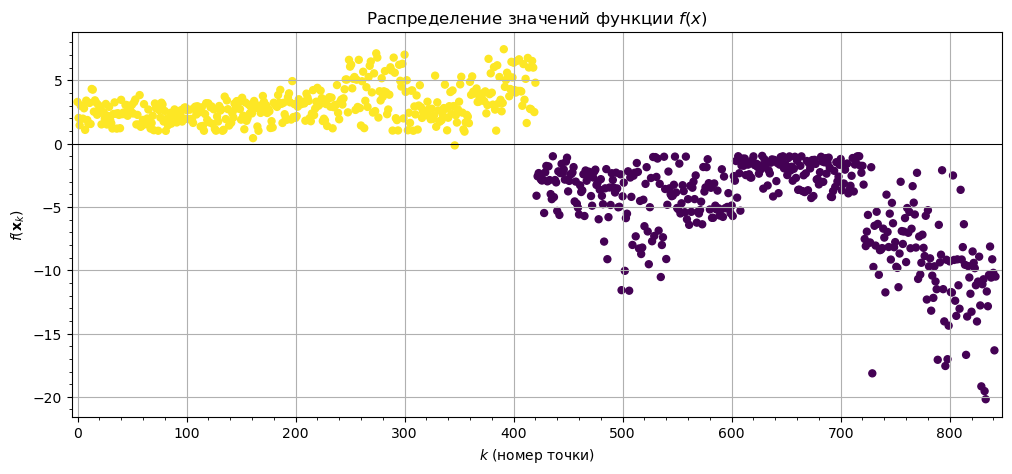

In [13]:
plt.figure(figsize=(12,5))
plots.plot_cls_function(mod1, XX, YY)
plt.show()

986


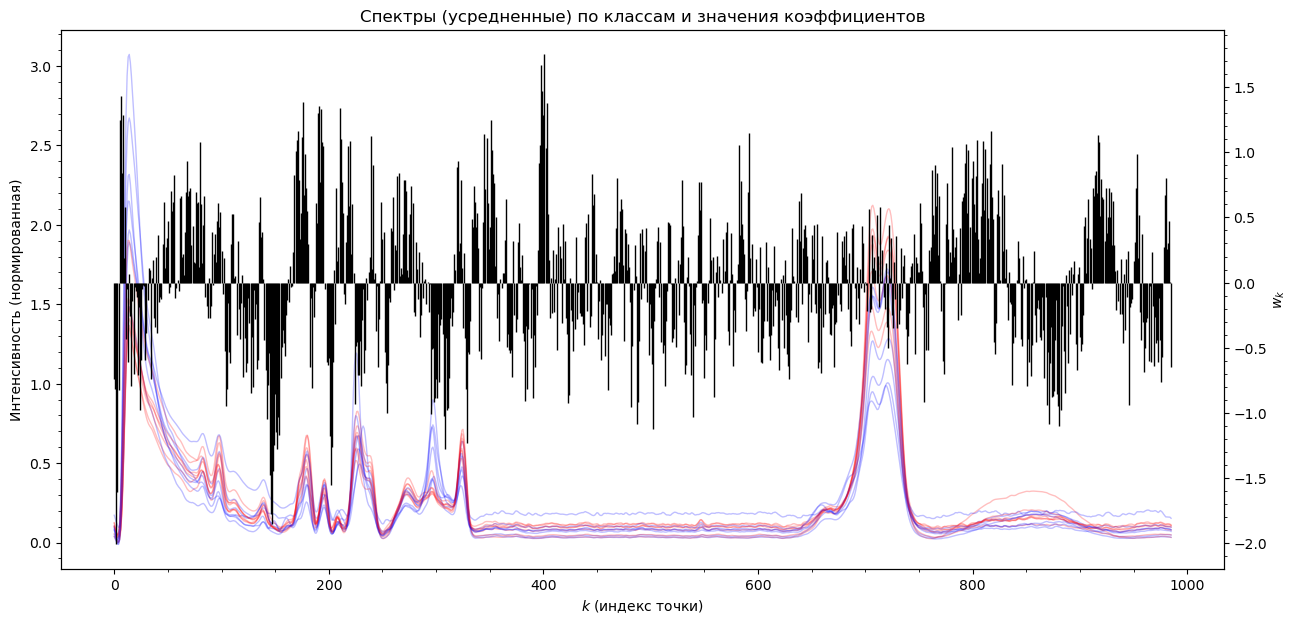

In [14]:
plt.figure(figsize=(15,7))
ax1 = plt.gca()
plot_spectra(d_191, d_606, ax=ax1)
ax2 = plt.twinx(ax1)
plot_params(mod1.param, ax=ax2)
plt.show()

### Линейное разделение (функция Хинжа, L2 регуляризация)

$$
w^\star = \arg \min_{\mathbf{w}} \frac{1}{N} \sum_{k=1}^N 
H\bigl(y_k[w_0+(\mathbf{w},\mathbf{x}_k)]\bigr) + \tau\|\mathbf{w}\|_2^2,
$$
$$
H(u) = \max(-u,0)
$$
$$
\|\mathbf{w}\|_2^2 = w_1^2+\cdots+w_n^2
$$

In [15]:
mod2 = models.LinearModel(n)

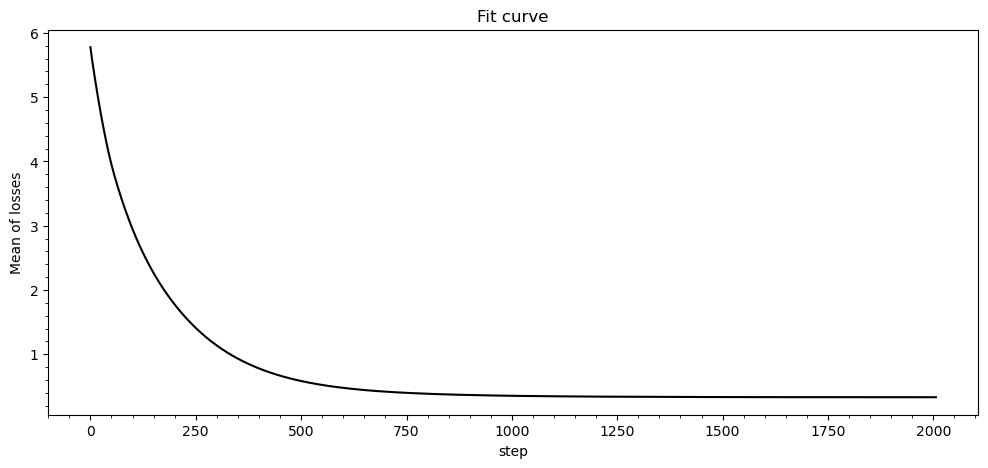

Относительное число правильных ответов: 0.9643705463182898 0.9265402843601895


In [16]:
alg2 = cls.classification_as_regr(XX, YY, mod2,
                                 lossfunc=hinge_loss, 
                                 regnorm=l2_reg, tau=0.1,
                                 normalizer=gd.Masked(mod2.n_param, 1.0e-5),
                                 h=0.001, n_iter=10000)
plt.figure(figsize=(12,5))
plots.plot_losses(alg2)
plt.show()

print("Относительное число правильных ответов:", 
        metrics.accuracy_score(YY1, np.sign(mod2.evaluate_all(XX1))),
        metrics.accuracy_score(YY2, np.sign(mod2.evaluate_all(XX2))))

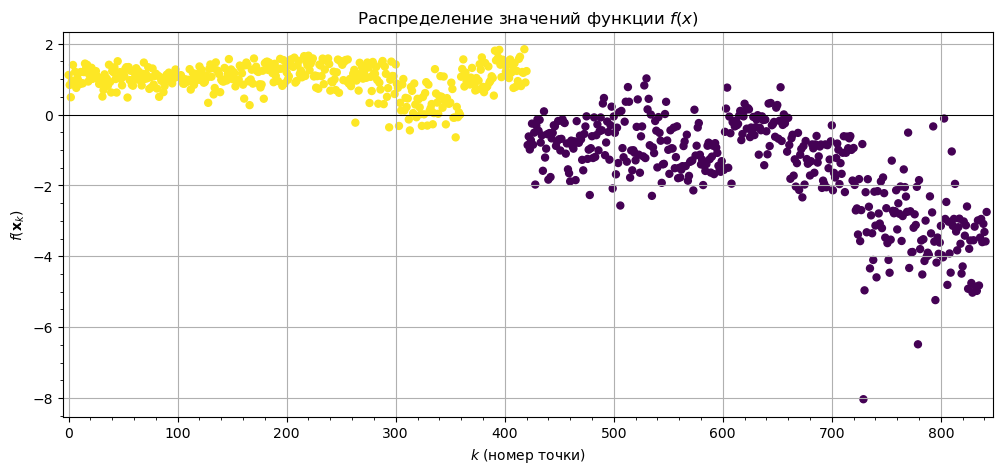

In [17]:
plt.figure(figsize=(12,5))
plots.plot_cls_function(mod2, XX, YY)
plt.show()

986


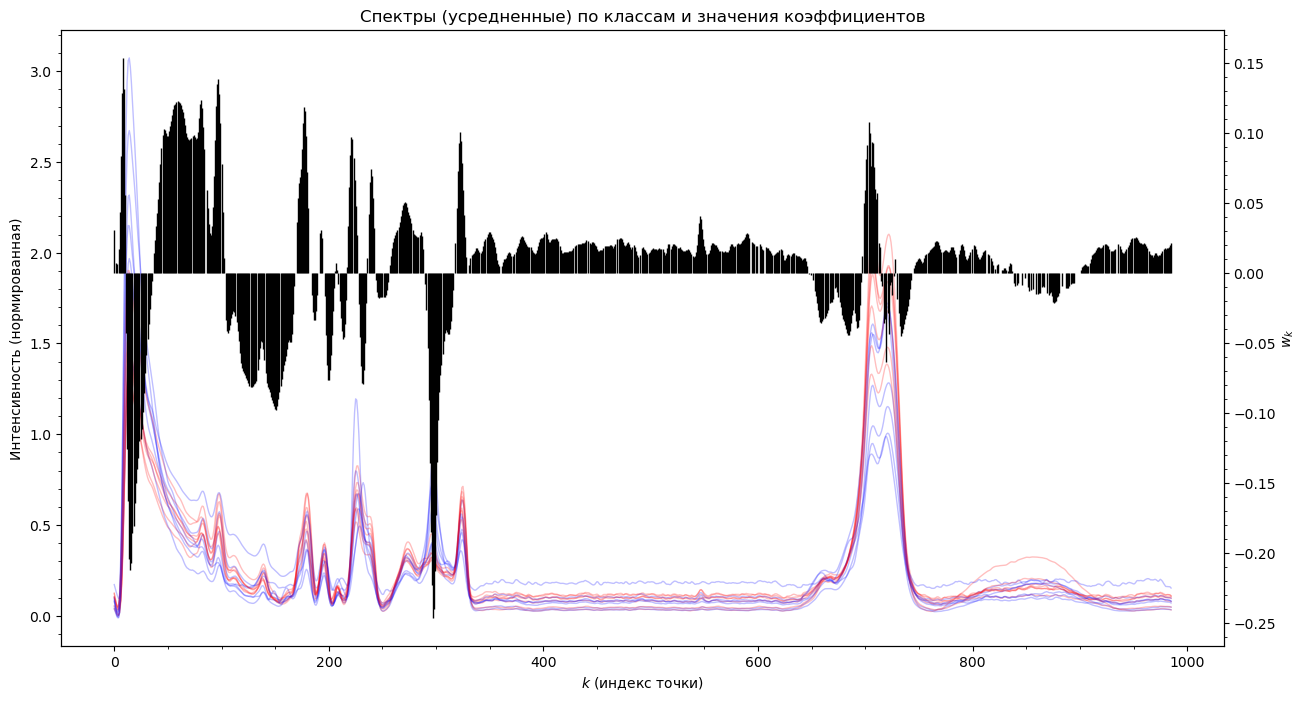

In [18]:
plt.figure(figsize=(15,8))
ax1 = plt.gca()
plot_spectra(d_191, d_606, ax=ax1)
ax2 = plt.twinx(ax1)
plot_params(mod2.param, ax=ax2)
plt.show()

### Линейное разделение (функция Хинжа, L1 регуляризацией)

$$
w^\star = \arg \min_{\mathbf{w}} \frac{1}{N} \sum_{k=1}^N 
H\bigl(y_k[w_0+(\mathbf{w},\mathbf{x}_k)]\bigr) + 
\tau\|\mathbf{w}\|_1,
$$
$$
H(u) = \max(-u,0)
$$
$$
\|\mathbf{w}\|_1 = |w_1|+\cdots+|w_n|
$$

In [11]:
mod3 = models.LinearModel(n)

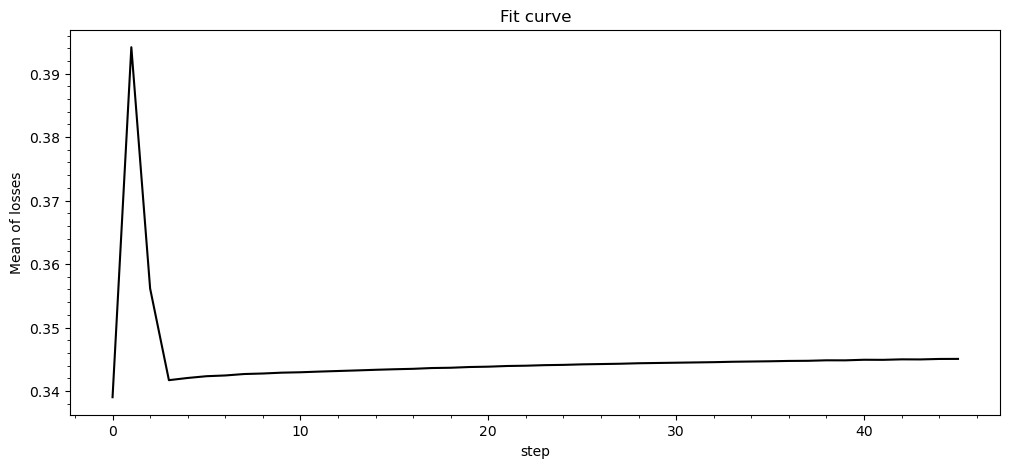

Относительное число правильных ответов: 0.9334916864608076 0.9597156398104265
41


In [13]:
alg3 = cls.classification_as_regr(XX, YY, mod3,
                                 lossfunc=hinge_loss, 
                                 regnorm=l1_reg, tau=0.01,
                                 normalizer=gd.Masked(mod3.n_param, 1.0e-5),
                                 h=0.002, n_iter=10000)
plt.figure(figsize=(12,5))
plots.plot_losses(alg3)
plt.show()

print("Относительное число правильных ответов:", 
        metrics.accuracy_score(YY1, np.sign(mod3.evaluate_all(XX1))),
        metrics.accuracy_score(YY2, np.sign(mod3.evaluate_all(XX2))))

print((mod3.param.base != 0).sum())

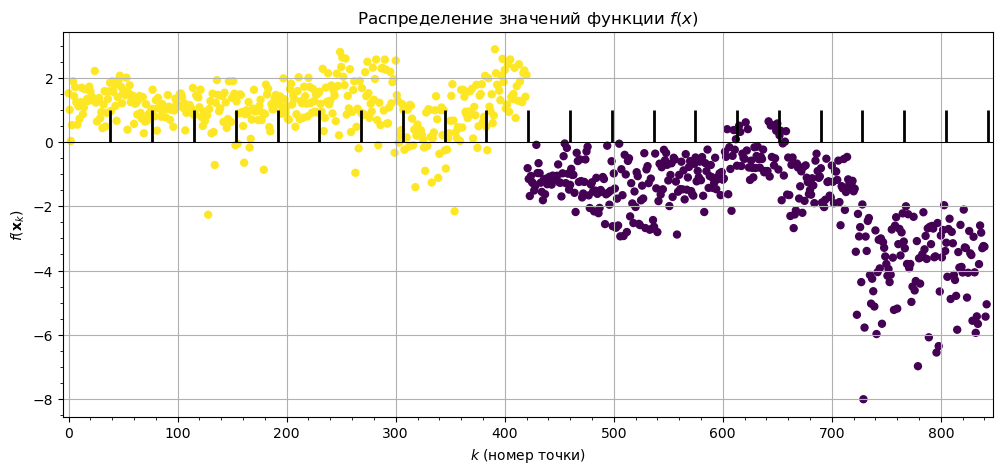

In [14]:
plt.figure(figsize=(12,5))
plots.plot_cls_function(mod3, XX, YY)
plt.vlines([i*len(XX)/22 for i in range(1,23)], 0, 1, color='k', linewidth=2)
plt.show()

986


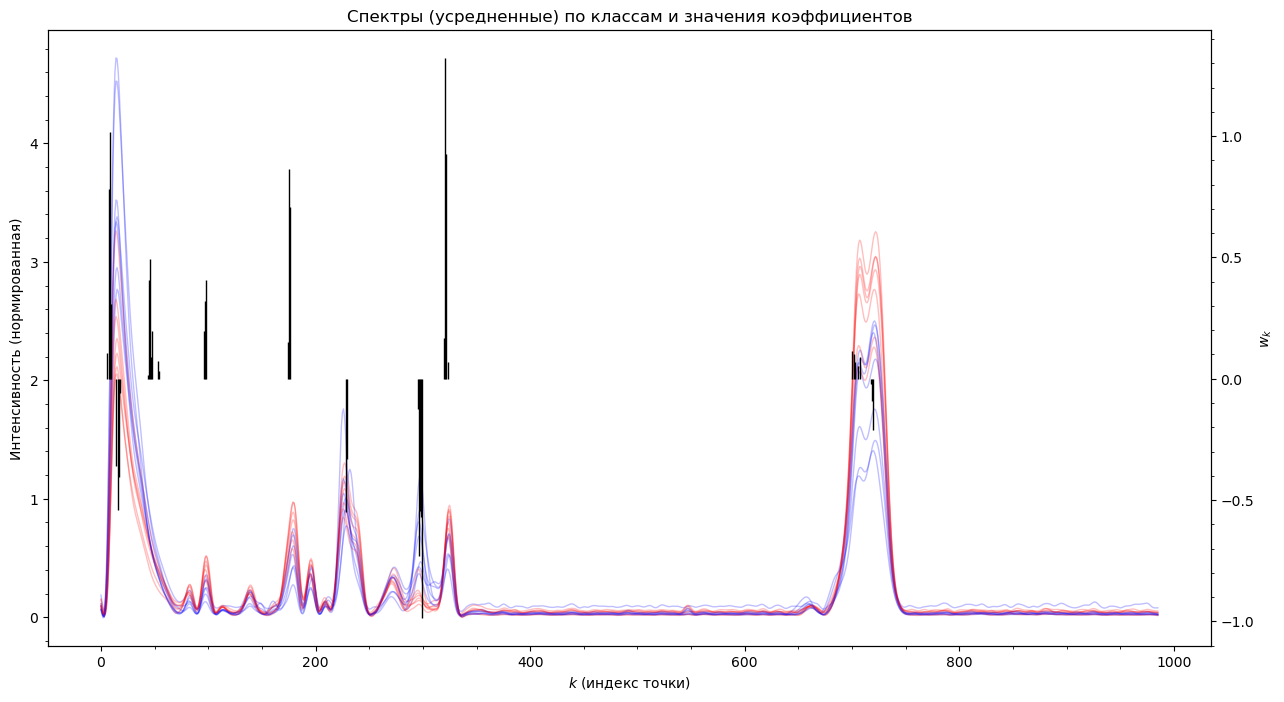

In [15]:
plt.figure(figsize=(15,8))
ax1 = plt.gca()
plot_spectra(d_191, d_606, ax=ax1)
ax2 = plt.twinx(ax1)
plot_params(mod3.param, ax=ax2)
plt.show()

## Линейное разделение (сигмоидальная функция)

$$
y = \sigma\bigl(w_0 + (\mathbf{w},\mathbf{x})\bigr)
$$
где
$$
\sigma(s) = \mathrm{th}(s) = \frac{e^{\alpha x} - e^{-\alpha x}}{e^{\alpha x} + e^{-\alpha x}}
$$

$$
w^\star = \arg \min_{\mathbf{w}} \frac{1}{N} \sum_{k=1}^N 
\bigl(\sigma(w_0+(\mathbf{w},\mathbf{x}_k)) - y_k\bigr)^2 
$$


In [23]:
mod1_s = models.SigmaNeuronModel(sigmoidal_func2, n)

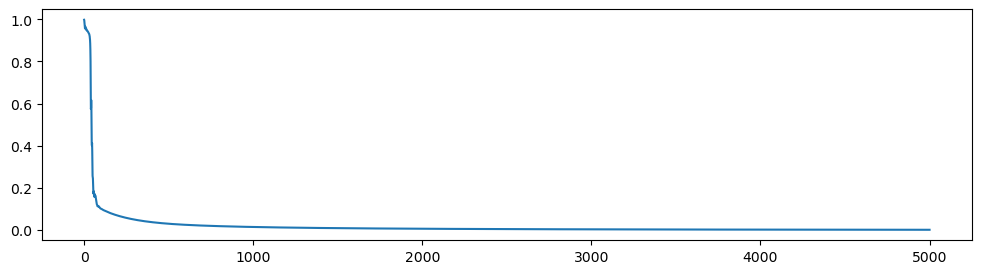

Относительное число правильных ответов: 1.0 1.0


In [24]:
alg1_s = cls.classification_as_regr(XX, YY, mod1_s,
                                 lossfunc=sq_loss,
                                 normalizer=gd.Masked(mod1_s.n_param, 1.0e-4),
                                 h=0.002, n_iter=5000)
plt.figure(figsize=(12,3))
plt.plot(alg1_s.lvals)
plt.show()

print("Относительное число правильных ответов:", 
        metrics.accuracy_score(YY1, np.sign(mod1_s.evaluate_all(XX1))),
        metrics.accuracy_score(YY2, np.sign(mod1_s.evaluate_all(XX2))))

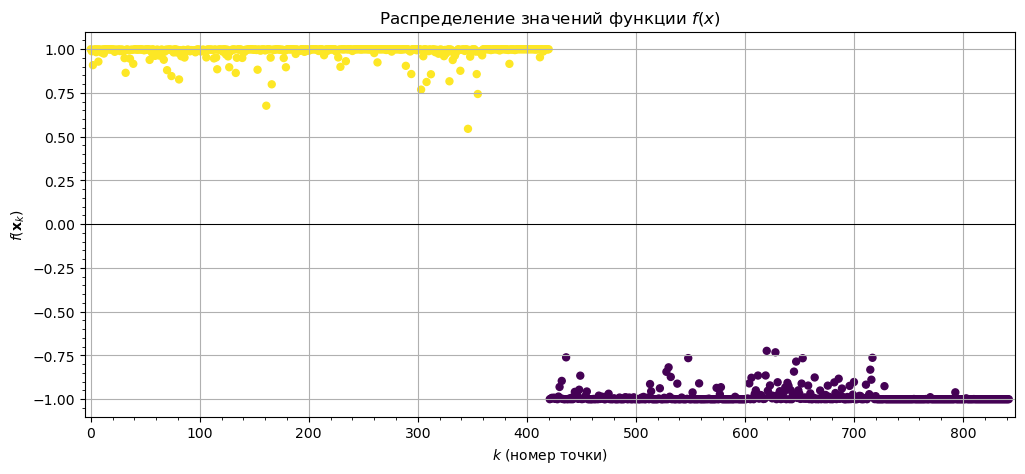

In [25]:
plt.figure(figsize=(12,5))
plots.plot_cls_function(mod1_s, XX, YY)
plt.show()

986


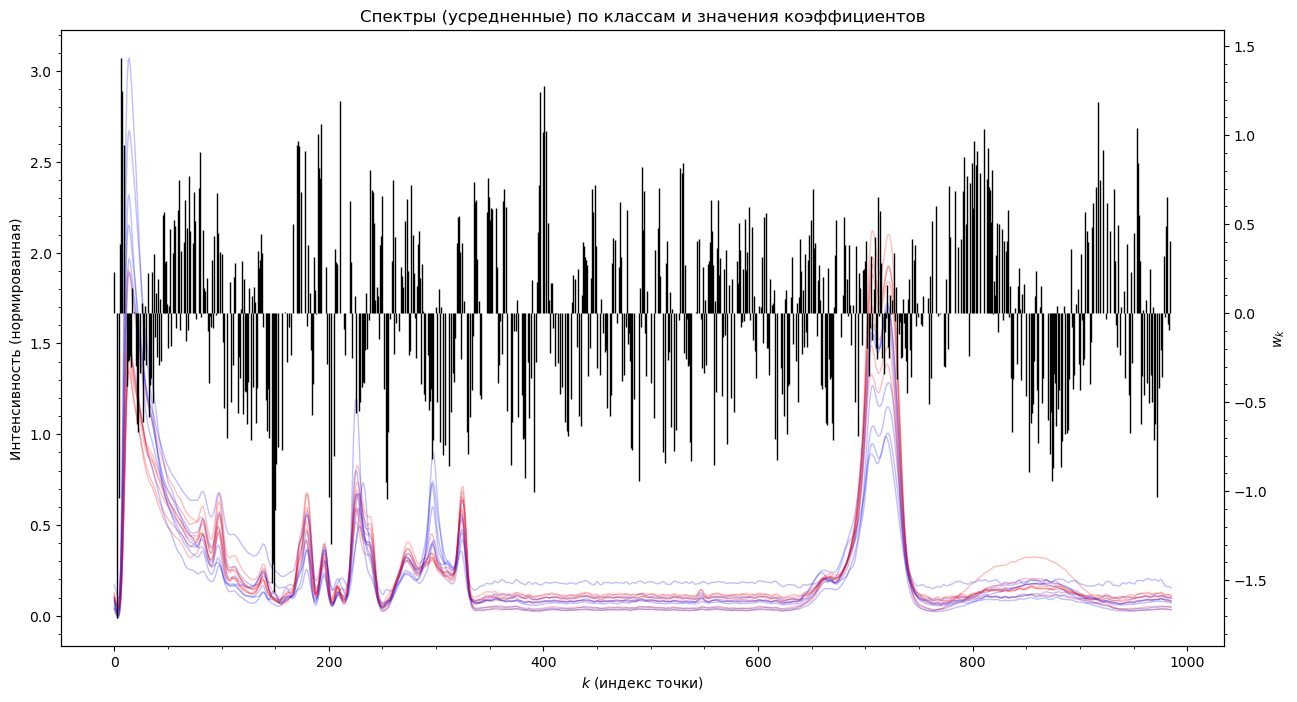

In [26]:
plt.figure(figsize=(15,8))
ax1 = plt.gca()
plot_spectra(d_191, d_606, ax=ax1)
ax2 = plt.twinx(ax1)
plot_params(mod1_s.param, ax=ax2)
plt.show()

### Линейное разделение (максимизация отступа, с L2 регуляризацией)

$$
w^\star = \arg \min_{\mathbf{w}} \frac{1}{N} \sum_{k=1}^N 
\bigl(\sigma(w_0+(\mathbf{w},\mathbf{x}_k)) - y_k\bigr)^2 + 
\tau\|\mathbf{w}\|_2^2,
$$
$$
\|\mathbf{w}\|_2^2 = w_1^2+\cdots+w_n^2
$$

In [51]:
mod2_s = models.SigmaNeuronModel(sigmoidal_func2, n)

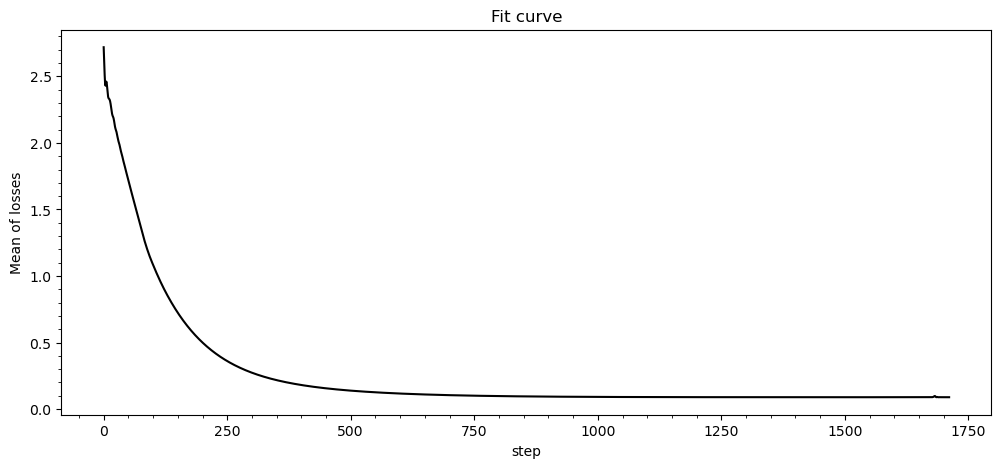

Относительное число правильных ответов: 0.9904988123515439 0.985781990521327


In [52]:
alg2_s = cls.classification_as_regr(XX, YY, mod2_s,
                                 lossfunc=sq_loss,
                                 regnorm=l2_reg, tau=0.05,
                                 normalizer=gd.Masked(mod2_s.n_param, 1.0e-5),
                                 h=0.002, n_iter=5000)
plt.figure(figsize=(12,5))
plots.plot_losses(alg2_s)
plt.show()

print("Относительное число правильных ответов:", 
        metrics.accuracy_score(YY1, np.sign(mod2_s.evaluate_all(XX1))),
        metrics.accuracy_score(YY2, np.sign(mod2_s.evaluate_all(XX2))))

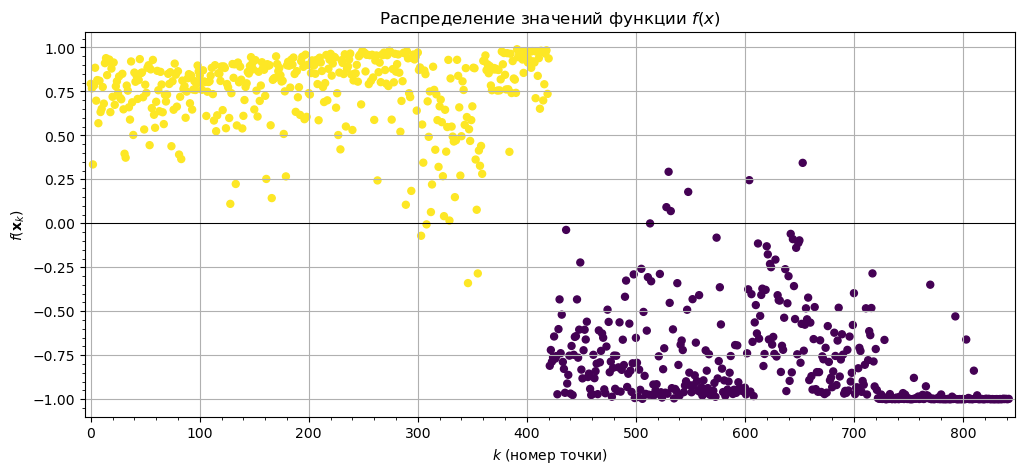

In [53]:
plt.figure(figsize=(12,5))
plots.plot_cls_function(mod2_s, XX, YY)
plt.show()

986


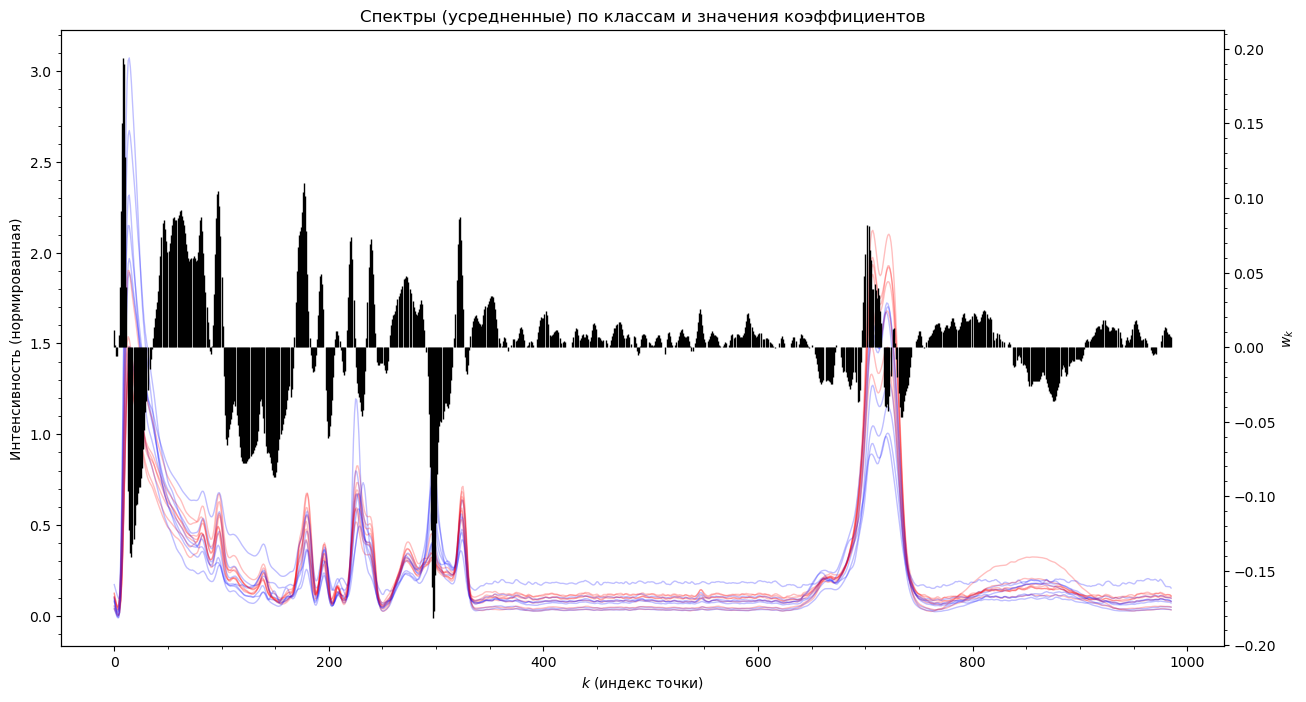

In [54]:
plt.figure(figsize=(15,8))
ax1 = plt.gca()
plot_spectra(d_191, d_606, ax=ax1)
ax2 = plt.twinx(ax1)
plot_params(mod2_s.param, ax=ax2)
plt.show()

### Линейное разделение (максимизация отступа, с L1 регуляризацией)

$$
w^\star = \arg \min_{\mathbf{w}} \frac{1}{N} \sum_{k=1}^N 
\sigma\bigl(y_k[w_0+(\mathbf{w},\mathbf{x}_k)]\bigr) + \tau\|\mathbf{w}\|_1,
$$
$$
\|\mathbf{w}\|_1 = |w_1|+\cdots+|w_n|
$$

In [21]:
mod3_s = models.SigmaNeuronModel(sigmoidal_func, n)

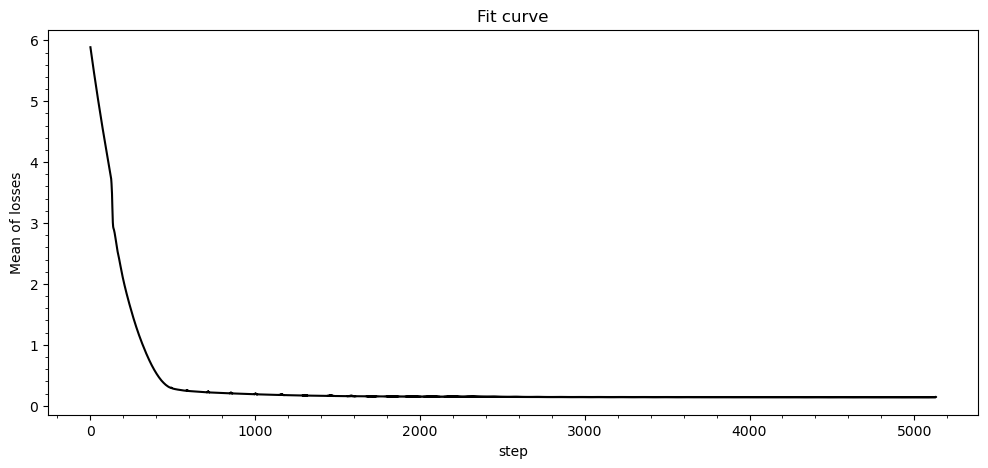

Относительное число правильных ответов: 0.9501187648456056 0.966824644549763 0.9584816132858838
18


In [22]:
alg3_s = cls.classification_as_regr(XX, YY, mod3_s,
                                 lossfunc=sq_loss, 
                                 regnorm=l1_reg, tau=0.02,
                                 normalizer=gd.Masked(mod3_s.n_param, 1.0e-5),
                                 h=0.001, n_iter=10000, n_restart=2)
plt.figure(figsize=(12,5))
plots.plot_losses(alg3_s)
plt.show()

print("Относительное число правильных ответов:", 
      metrics.accuracy_score(YY1, np.sign(mod3_s.evaluate_all(XX1))),
      metrics.accuracy_score(YY2, np.sign(mod3_s.evaluate_all(XX2))),
      metrics.accuracy_score(YY, np.sign(mod3_s.evaluate_all(XX))),)

print((mod3_s.param.base != 0).sum())

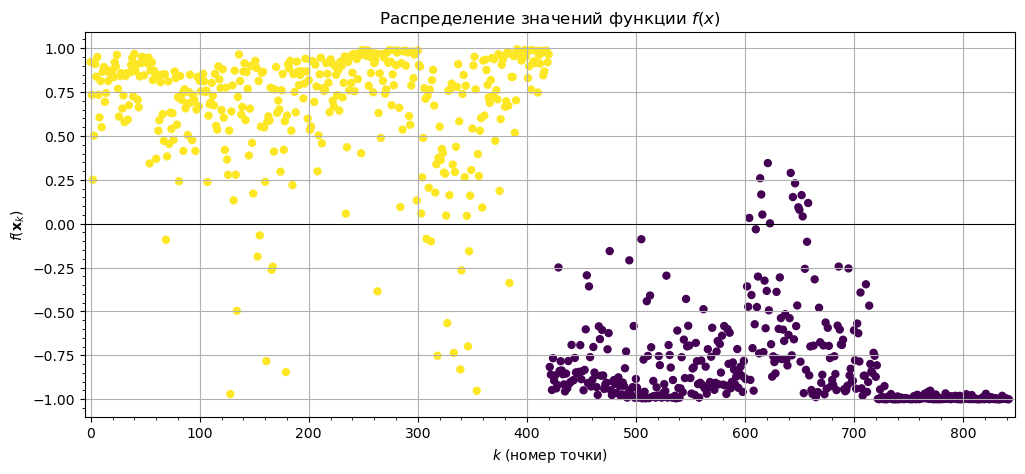

In [23]:
plt.figure(figsize=(12,5))
plots.plot_cls_function(mod3_s, XX, YY)
plt.show()

986


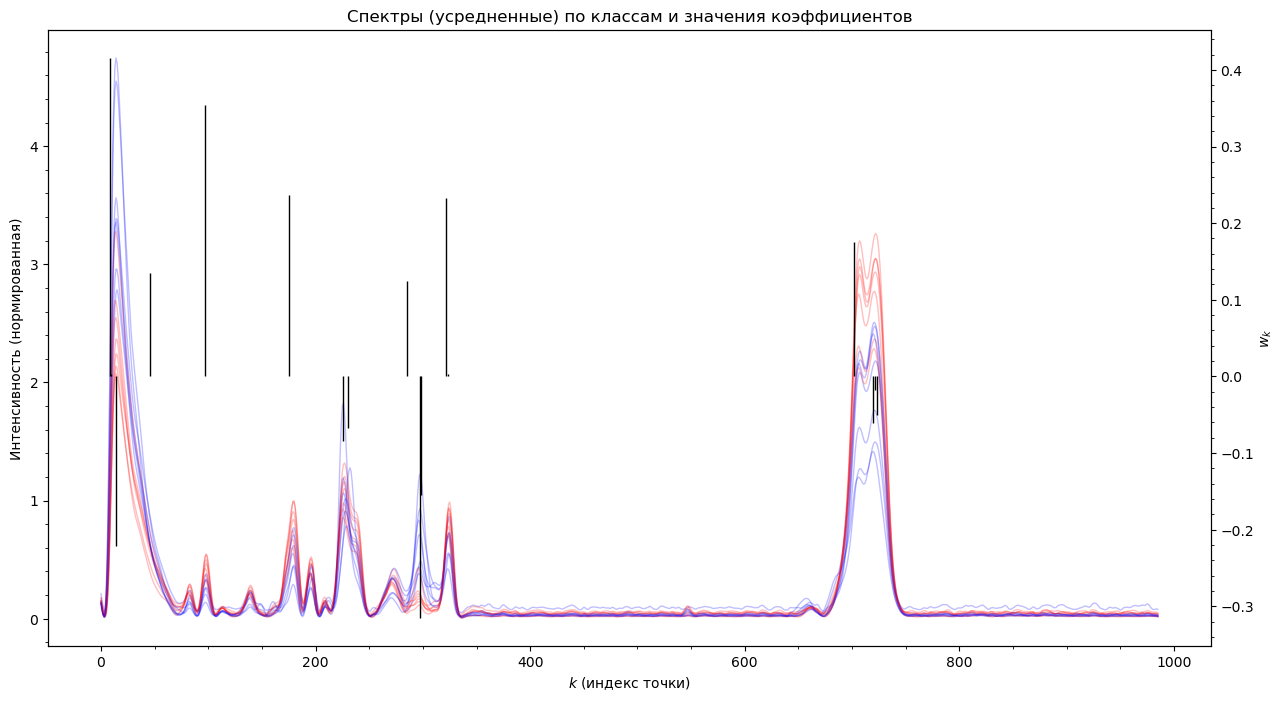

In [24]:
plt.figure(figsize=(15,8))
ax1 = plt.gca()
plot_spectra(d_191, d_606, ax=ax1)
ax2 = plt.twinx(ax1)
plot_params(mod3_s.param, ax=ax2)
plt.show()

In [25]:
counts = np.zeros(XX.shape[1], 'i')
for i in range(50):
    _mod = models.SigmaNeuronModel(sigmoidal_func, n)
    _alg = cls.classification_as_regr(XX, YY, _mod,
                                     lossfunc=sq_loss, 
                                     regnorm=l1_reg, tau=0.02,
                                     normalizer=gd.Masked(_mod.n_param, 1.0e-5),
                                     h=0.001, n_iter=10000, n_restart=2)
    
    I = np.argwhere(abs(_alg.risk.param.base[1:]) > 0)[:,0]
    counts[I] += 1

# print(counts)

985


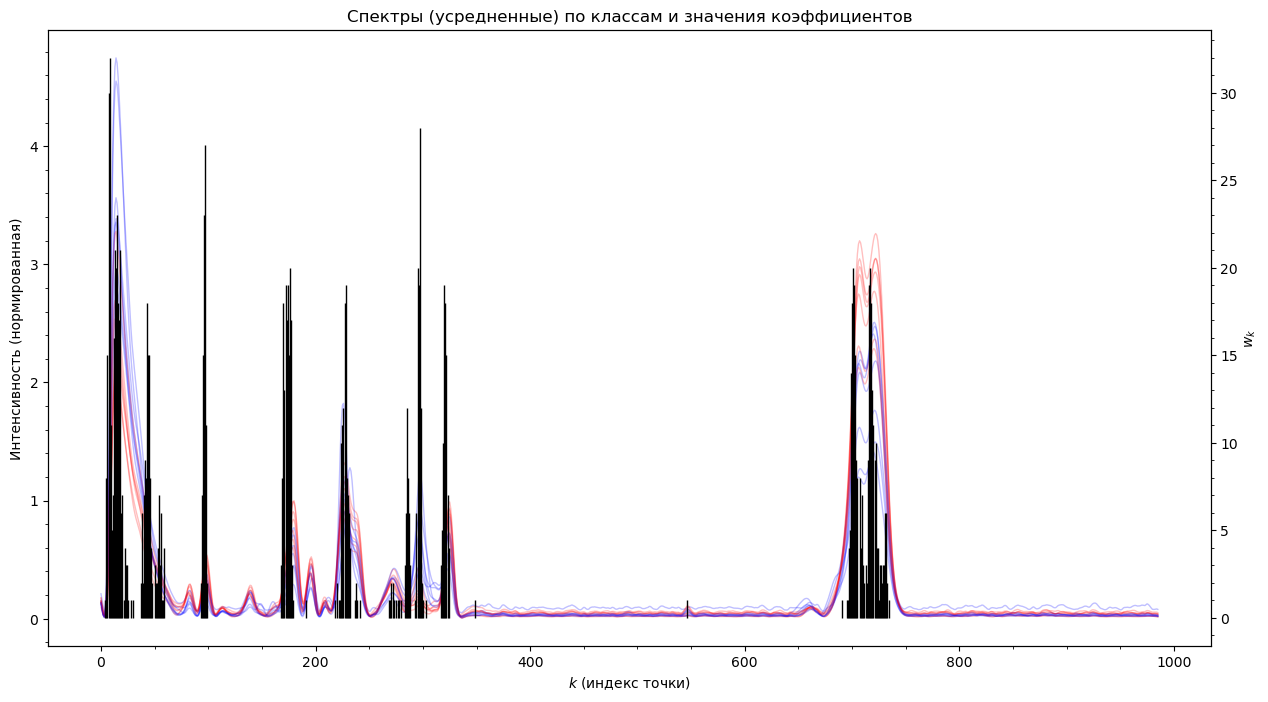

In [27]:
plt.figure(figsize=(15,8))
ax1 = plt.gca()
plot_spectra(d_191, d_606, ax=ax1)
ax2 = plt.twinx(ax1)
plot_params(counts, ax=ax2)
plt.show()

In [28]:
I1 = np.argwhere(counts > 5)[:,0]
XXI = np.ascontiguousarray(XX[:,I1])
print(XXI.shape, YY.shape)

(843, 80) (843,)


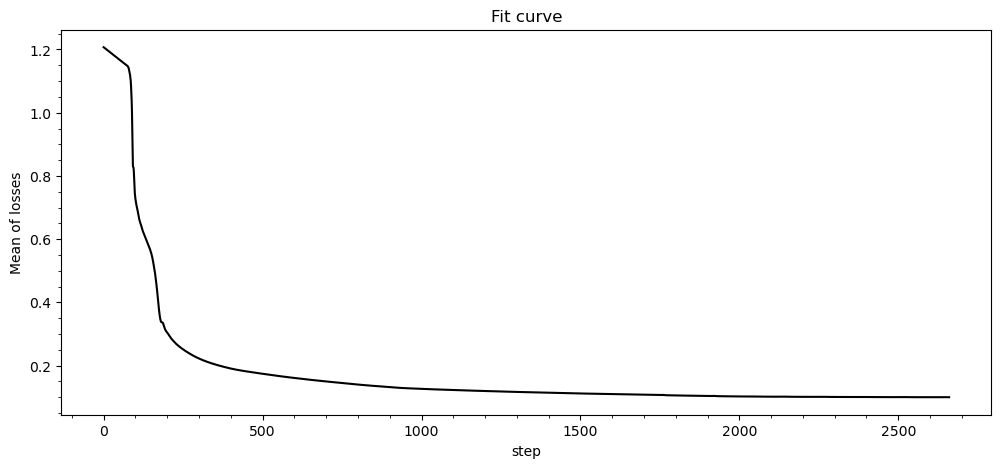

Относительное число правильных ответов: 0.9727164887307236


In [30]:
mod3_s1 = models.SigmaNeuronModel(sigmoidal_func, XXI.shape[1])
alg3_s1 = cls.classification_as_regr(XXI, YY, mod3_s1,
                                 lossfunc=sq_loss, 
                                 regnorm=l1_reg, tau=0.01,
                                 normalizer=gd.Masked(mod3_s1.n_param, 1.0e-5),
                                 h=0.001, n_iter=10000, n_restart=1)
plt.figure(figsize=(12,5))
plots.plot_losses(alg3_s1)
plt.show()

print("Относительное число правильных ответов:", 
      # metrics.accuracy_score(YY1, np.sign(mod3_s1.evaluate_all(XX1[I1]))),
      # metrics.accuracy_score(YY2, np.sign(mod3_s1.evaluate_all(XX2[I1]))),
      metrics.accuracy_score(YY, np.sign(mod3_s1.evaluate_all(XXI))),)

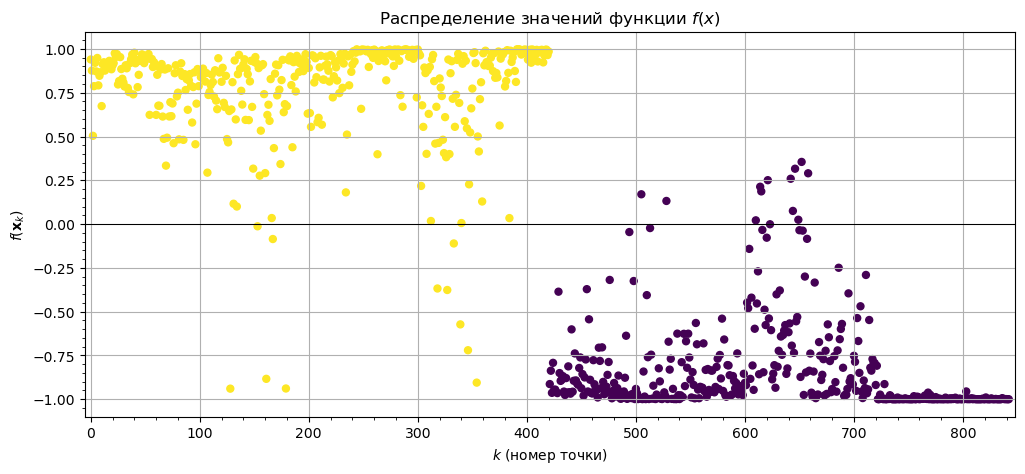

In [31]:
plt.figure(figsize=(12,5))
plots.plot_cls_function(mod3_s1, XXI, YY)
plt.show()

986


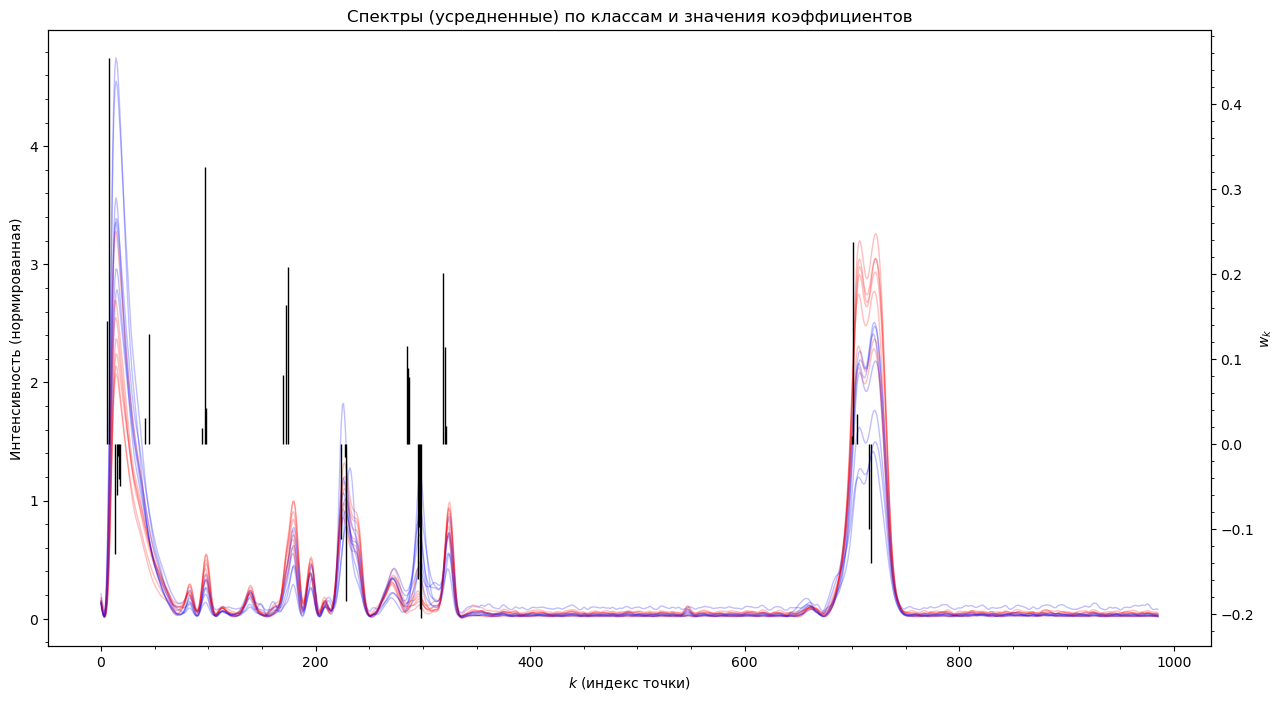

In [34]:
p = np.zeros(XX.shape[1]+1, 'd')
p[I1] = mod3_s1.param[1:]
p[0] = mod3_s1.param[0]

plt.figure(figsize=(15,8))
ax1 = plt.gca()
plot_spectra(d_191, d_606, ax=ax1)
ax2 = plt.twinx(ax1)
plot_params(p, ax=ax2)
plt.show()

In [39]:
# n_hidden = 10
# linear4 = models.LinearLayer(XX.shape[1], n_hidden)
# scaler4 = models.ScaleLayer(sigmoidal_func, n_hidden)
# body4 = models.FFNetworkModel()
# body4.add(linear4)
# body4.add(scaler4)
# head4 = models.LinearModel(n_hidden)
# mod4_s = models.FFNetworkFuncModel(head4, body4)
# mod4_s.allocate()
# mod4_s.init_param()

In [40]:
# alg4_s = cls.classification_as_regr(XX, YY, mod4_s,
#                                  lossfunc=sq_loss, 
#                                  regnorm=l1_reg, tau=0.01,
#                                  normalizer=gd.Masked(mod4_s.n_param, 1.0e-5),
#                                  h=0.001, n_iter=10000)
# plt.figure(figsize=(12,5))
# plots.plot_losses(alg4_s)
# plt.show()

# print("Относительное число правильных ответов:", 
#       metrics.accuracy_score(YY1, np.sign(mod4_s.evaluate_all(XX1))),
#       metrics.accuracy_score(YY2, np.sign(mod4_s.evaluate_all(XX2))))

In [41]:
# # plt.figure(figsize=(12,5))
# plots.plot_cls_function(mod4_s, XX, YY)
# plt.show()

In [42]:
# plt.figure(figsize=(20,4))
# plot_params(mod4_s)
# plt.vlines([n_hidden+XX.shape[1]*i for i in range(n_hidden)], 0,4)
# plt.show()

In [43]:
# n_hidden = 7
# linear5 = models.LinearLayer(XX.shape[1], n_hidden)
# scaler5 = models.ScaleLayer(sigmoidal_func, n_hidden)
# body5 = models.FFNetworkModel()
# body5.add(linear5)
# body5.add(scaler5)
# head5 = models.LinearModel(n_hidden)
# mod5_s = models.FFNetworkFuncModel(head5, body5)
# mod5_s.allocate()
# mod5_s.init_param()

In [44]:
# alg5_s = cls.classification_as_regr(XX, YY, mod5_s,
#                                  lossfunc=hinge_loss, 
#                                  regnorm=l1_reg, tau=0.001,
#                                  normalizer=gd.Masked(mod5_s.n_param, 1.0e-4),
#                                  h=0.001, n_iter=10000, n_restart=3)
# plt.figure(figsize=(12,5))
# plots.plot_losses(alg5_s)
# plt.show()

# print("Относительное число правильных ответов:", 
#       metrics.accuracy_score(YY1, np.sign(mod5_s.evaluate_all(XX1))),
#       metrics.accuracy_score(YY2, np.sign(mod5_s.evaluate_all(XX2))))

In [45]:
# plt.figure(figsize=(12,5))
# plots.plot_cls_function(mod5_s, XX, YY)
# plt.show()

In [46]:
# plt.figure(figsize=(20,4))
# plot_params(mod5_s)
# plt.vlines([n_hidden+(XX.shape[1]+1)*i for i in range(n_hidden)], 0,3)
# plt.show()